In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('diabetesMLnew.csv')

In [11]:
df

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,80.0,0,1,never smoked,25.19,6.6,140,0
1,54.0,0,0,Unknown,27.32,6.6,80,0
2,28.0,0,0,never smoked,27.32,5.7,158,0
3,36.0,0,0,smokes,23.45,5.0,155,0
4,76.0,1,1,smokes,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...
83315,36.0,0,0,Unknown,24.60,4.8,145,0
83316,2.0,0,0,Unknown,17.37,6.5,100,0
83317,66.0,0,0,formerly smoked,27.83,5.7,155,0
83318,24.0,0,0,never smoked,35.42,4.0,100,0


In [12]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [17]:
categorical_features = ['smoking_history']
numeric_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [21]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# LogisticRegression

In [48]:
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

In [50]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('smote', SMOTE(random_state=42)),
                           ('classifier', logreg)])

In [52]:
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

In [54]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'hypertension',
                                                                          'heart_disease',
                                                                          'bmi',
                                                                          'HbA1c_level',
                                                                          'blood_glucose_level']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['smoking_history'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           solver='liblinear'))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [55]:
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

In [56]:
print("Best hyperparameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))

Best hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.99      0.89      0.93     22804
           1       0.43      0.89      0.58      2192

    accuracy                           0.89     24996
   macro avg       0.71      0.89      0.76     24996
weighted avg       0.94      0.89      0.90     24996

ROC AUC Score: 0.9652862456420119


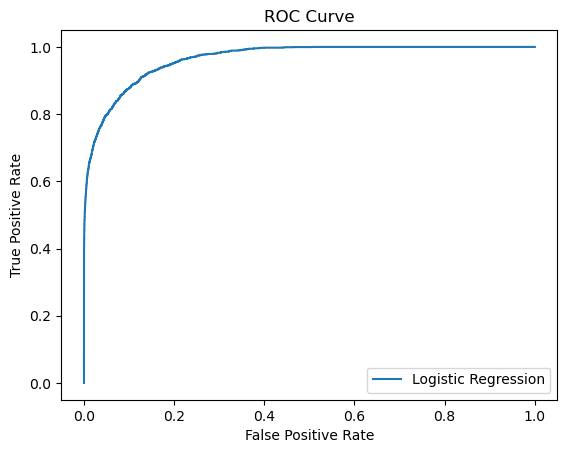

In [57]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# KNN

In [63]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
knn = KNeighborsClassifier()

In [67]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('smote', SMOTE(random_state=42)),
                           ('classifier', knn)])

In [69]:
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

In [71]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'hypertension',
                                                                          'heart_disease',
                                                                          'bmi',
                                                                          'HbA1c_level',
                                                                          'blood_glucose_level']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['smoking_history'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__metric': ['euclidean', 'manhattan',
                                                'minkowski'],
                         'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [72]:
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

In [73]:
print("Best hyperparameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))

Best hyperparameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 15, 'classifier__weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     22804
           1       0.46      0.86      0.60      2192

    accuracy                           0.90     24996
   macro avg       0.72      0.88      0.77     24996
weighted avg       0.94      0.90      0.91     24996

ROC AUC Score: 0.9512242417772783


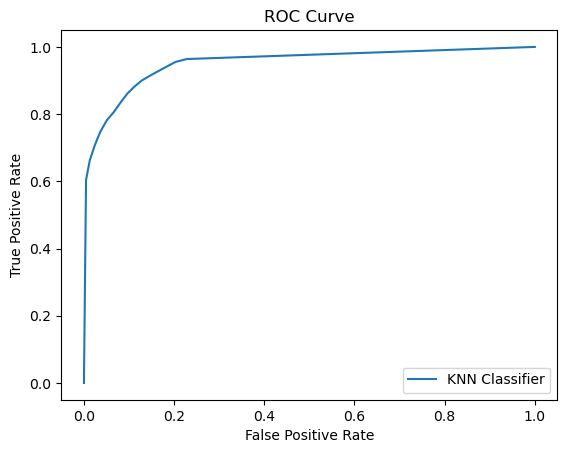

In [74]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="KNN Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# SVM

In [25]:
from sklearn.svm import SVC
svm = SVC(probability=True)

In [27]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('smote', SMOTE(random_state=42)),
                           ('classifier', svm)])

In [29]:
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

In [ ]:
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

In [ ]:
print("Best hyperparameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="SVM Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()